<a href="https://colab.research.google.com/github/aatharvauti/Healthcare-Fraud-Detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os

In [3]:
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings     # for supressing a warning when importing large files
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42

LABELS = ["Normal", "Fraud"]

In [4]:
PATH = '/content/drive/MyDrive/AIML Mini Project/data/'

In [5]:
# Load Train Dataset

Train=pd.read_csv(PATH + "Train-1542865627584.csv")
Train_Beneficiarydata=pd.read_csv(PATH + "Train_Beneficiarydata-1542865627584.csv")
Train_Inpatientdata=pd.read_csv(PATH + "Train_Inpatientdata-1542865627584.csv")
Train_Outpatientdata=pd.read_csv(PATH + "Train_Outpatientdata-1542865627584.csv")

# Load Test Dataset

Test=pd.read_csv(PATH + "Test-1542969243754.csv")
Test_Beneficiarydata=pd.read_csv(PATH + "Test_Beneficiarydata-1542969243754.csv")
Test_Inpatientdata=pd.read_csv(PATH + "Test_Inpatientdata-1542969243754.csv")
Test_Outpatientdata=pd.read_csv(PATH + "Test_Outpatientdata-1542969243754.csv")

Replacing the chronic diseases with either other or one!

In [6]:
##Replacing 2 with 0 for chronic conditions ,that means chronic condition No is 0 and yes is 1

Train_Beneficiarydata = Train_Beneficiarydata.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

Train_Beneficiarydata = Train_Beneficiarydata.replace({'RenalDiseaseIndicator': 'Y'}, 1)

Test_Beneficiarydata = Test_Beneficiarydata.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

Test_Beneficiarydata = Test_Beneficiarydata.replace({'RenalDiseaseIndicator': 'Y'}, 1)

Add Age of Person based on his/her DOD(Date of death ) and DOB (Date of Birth)

In [7]:
## Lets Create Age column to the dataset

Train_Beneficiarydata['DOB'] = pd.to_datetime(Train_Beneficiarydata['DOB'] , format = '%Y-%m-%d')
Train_Beneficiarydata['DOD'] = pd.to_datetime(Train_Beneficiarydata['DOD'],format = '%Y-%m-%d',errors='ignore')
Train_Beneficiarydata['Age'] = round(((Train_Beneficiarydata['DOD'] - Train_Beneficiarydata['DOB']).dt.days)/365)


Test_Beneficiarydata['DOB'] = pd.to_datetime(Test_Beneficiarydata['DOB'] , format = '%Y-%m-%d')
Test_Beneficiarydata['DOD'] = pd.to_datetime(Test_Beneficiarydata['DOD'],format = '%Y-%m-%d',errors='ignore')
Test_Beneficiarydata['Age'] = round(((Test_Beneficiarydata['DOD'] - Test_Beneficiarydata['DOB']).dt.days)/365)

In [8]:
## As we see that last DOD value is 2009-12-01 ,which means Beneficiary Details data is of year 2009.
## so we will calculate age of other benficiaries for year 2009.

Train_Beneficiarydata.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - Train_Beneficiarydata['DOB']).dt.days)/365),
                                 inplace=True)


Test_Beneficiarydata.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - Test_Beneficiarydata['DOB']).dt.days)/365),
                                 inplace=True)

Add Flag column 'WhetherDead' using DOD values to tell whether beneficiary is dead on not

In [9]:
#Lets create a new variable 'WhetherDead' with flag 1 means Dead and 0 means not Dead

Train_Beneficiarydata.loc[Train_Beneficiarydata.DOD.isna(),'WhetherDead']=0
Train_Beneficiarydata.loc[Train_Beneficiarydata.DOD.notna(),'WhetherDead']=1
Train_Beneficiarydata.loc[:,'WhetherDead'].head(7)


Test_Beneficiarydata.loc[Test_Beneficiarydata.DOD.isna(),'WhetherDead']=0
Test_Beneficiarydata.loc[Test_Beneficiarydata.DOD.notna(),'WhetherDead']=1
Test_Beneficiarydata.loc[:,'WhetherDead'].head(3)

0    0.0
1    1.0
2    0.0
Name: WhetherDead, dtype: float64

Create new column 'AdmitForDays' indicating number of days patient was admitted in hospital

In [10]:
## As patient can be admitted for only for 1 day,we will add 1 to the difference of Discharge Date and Admission Date

Train_Inpatientdata['AdmissionDt'] = pd.to_datetime(Train_Inpatientdata['AdmissionDt'] , format = '%Y-%m-%d')
Train_Inpatientdata['DischargeDt'] = pd.to_datetime(Train_Inpatientdata['DischargeDt'],format = '%Y-%m-%d')
Train_Inpatientdata['AdmitForDays'] = ((Train_Inpatientdata['DischargeDt'] - Train_Inpatientdata['AdmissionDt']).dt.days)+1


Test_Inpatientdata['AdmissionDt'] = pd.to_datetime(Test_Inpatientdata['AdmissionDt'] , format = '%Y-%m-%d')
Test_Inpatientdata['DischargeDt'] = pd.to_datetime(Test_Inpatientdata['DischargeDt'],format = '%Y-%m-%d')
Test_Inpatientdata['AdmitForDays'] = ((Test_Inpatientdata['DischargeDt'] - Test_Inpatientdata['AdmissionDt']).dt.days)+1

Outpatient Data understanding

Lets Check null values in each columnn of outpatient data

Data Merging

As we see columns in inpatient and outpatient data are similar, we will merge this data based on these similar keys using outer join.

In [11]:
Key_Column_To_Merge_Outpatient=Train_Outpatientdata.columns
print(Key_Column_To_Merge_Outpatient)

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
      dtype='object')


Merge Inpatient and Outpatinet data and create dataset for all patients.

In [12]:
# Lets make union of Inpatienta and outpatient data .
# We will use all keys in outpatient data as we want to make union and dont want duplicate columns from both tables.

Train_Allpatientdata=pd.merge(Train_Outpatientdata,Train_Inpatientdata,
                              left_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
                              right_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode']
                              ,how='outer')


Test_Allpatientdata=pd.merge(Test_Outpatientdata,Test_Inpatientdata,
                              left_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
                              right_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode']
                              ,how='outer')

Merge Beneficiary details to All Patients data

In [13]:
## Lets merge All patient data with beneficiary details data based on 'BeneID' as joining key for inner join
Train_AllPatientDetailsdata=pd.merge(Train_Allpatientdata,Train_Beneficiarydata,left_on='BeneID',right_on='BeneID',how='inner')

Test_AllPatientDetailsdata=pd.merge(Test_Allpatientdata,Test_Beneficiarydata,left_on='BeneID',right_on='BeneID',how='inner')

In [14]:
## Lets Print shape of data
print('Shape of All Patient Details Train : ',Train_AllPatientDetailsdata.shape)
Train_AllPatientDetailsdata.head()

print('Shape of All Patient Details Test : ',Test_AllPatientDetailsdata.shape)
Test_AllPatientDetailsdata.head(5)

Shape of All Patient Details Train :  (558211, 57)
Shape of All Patient Details Test :  (135392, 57)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,WhetherDead
0,BENE11001,CLM392397,2009-06-02,2009-06-02,PRV55962,30,PHY347633,NaN,PHY347633,V5832,...,1,0,1,1,36000,3204,60,70,67.0,0.0
1,BENE11001,CLM430760,2009-06-23,2009-06-23,PRV56112,30,PHY381777,NaN,PHY381777,9594,...,1,0,1,1,36000,3204,60,70,67.0,0.0
2,BENE11007,CLM233081,2009-03-07,2009-03-07,PRV56979,200,PHY425311,NaN,PHY425311,7248,...,0,1,1,0,0,0,1490,160,69.0,1.0
3,BENE11007,CLM496381,2009-07-29,2009-07-29,PRV56573,10,PHY393253,PHY347995,NaN,58889,...,0,1,1,0,0,0,1490,160,69.0,1.0
4,BENE11007,CLM521391,2009-08-12,2009-08-12,PRV56573,10,PHY417685,NaN,PHY382041,V666,...,0,1,1,0,0,0,1490,160,69.0,1.0


Merge PotentialFraud details for each provider to create ProviderWithPatientDetails data

In [15]:
# Lets merge patient data with fradulent providers details data with "Provider" as joining key for inner join

Train_ProviderWithPatientDetailsdata=pd.merge(Train,Train_AllPatientDetailsdata,on='Provider')

Test_ProviderWithPatientDetailsdata=pd.merge(Test,Test_AllPatientDetailsdata,on='Provider')

In [16]:
### Lets check missing value percentage in full datasets

#print('Percent missing values in Train Provider with patient details data :\n')
Train_ProviderWithPatientDetailsdata.isnull().sum()*100/len(Train_ProviderWithPatientDetailsdata)


Test_ProviderWithPatientDetailsdata.isnull().sum()*100/len(Test_ProviderWithPatientDetailsdata)

Provider                             0.000000
BeneID                               0.000000
ClaimID                              0.000000
ClaimStartDt                         0.000000
ClaimEndDt                           0.000000
InscClaimAmtReimbursed               0.000000
AttendingPhysician                   0.256293
OperatingPhysician                  79.915357
OtherPhysician                      64.080596
ClmDiagnosisCode_1                   1.904101
ClmDiagnosisCode_2                  35.293814
ClmDiagnosisCode_3                  56.682817
ClmDiagnosisCode_4                  70.739039
ClmDiagnosisCode_5                  80.207102
ClmDiagnosisCode_6                  85.109903
ClmDiagnosisCode_7                  88.341261
ClmDiagnosisCode_8                  90.603581
ClmDiagnosisCode_9                  92.705625
ClmDiagnosisCode_10                 99.150615
ClmProcedureCode_1                  95.962095
ClmProcedureCode_2                  99.067153
ClmProcedureCode_3                

Exploratory Data Analysis

Plot Potential fraud class proportion in both Train and Merged data

In [17]:
## Lets create a copy of test data first and merge test with train to get better feature averages

Test_ProviderWithPatientDetailsdata_copy = Test_ProviderWithPatientDetailsdata

### We will concat two datasets using columns of Test data only as we dont see target column in Test data.

col_merge=Test_ProviderWithPatientDetailsdata.columns

## Lets add both test and train datasets

Test_ProviderWithPatientDetailsdata=pd.concat([Test_ProviderWithPatientDetailsdata,
                                               Train_ProviderWithPatientDetailsdata[col_merge]])

Average Features based on grouping variables. Average features grouped by Provider

In [18]:
Train_ProviderWithPatientDetailsdata["PerProviderAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_Age"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['Age'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_NoOfMonths_PartACov"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['NoOfMonths_PartACov'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_NoOfMonths_PartBCov"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['NoOfMonths_PartBCov'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerProviderAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_Age"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['Age'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_NoOfMonths_PartACov"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['NoOfMonths_PartACov'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_NoOfMonths_PartBCov"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['NoOfMonths_PartBCov'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['AdmitForDays'].transform('mean')

Average features grouped by BeneID

In [19]:
## Grouping based on BeneID explains amounts involved per beneficiary.Reason to derive this feature is that one beneficiary
## can go to multiple providers and can be involved in fraud cases
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['AdmitForDays'].transform('mean')

Average features grouped by OtherPhysician

In [20]:
### Average features grouped by OtherPhysician.

Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['AdmitForDays'].transform('mean')

Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['AdmitForDays'].transform('mean')

Average features grouped by OperatingPhysician

In [21]:
##Average features grouped by OperatingPhysician

Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['AdmitForDays'].transform('mean')

Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['AdmitForDays'].transform('mean')

Average features grouped by AttendingPhysician

In [22]:
### Average features grouped by AttendingPhysician

Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['AdmitForDays'].transform('mean')

Average features grouped by DiagnosisGroupCode

In [23]:
###  Average features grouped by DiagnosisGroupCode

Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['AdmitForDays'].transform('mean')

Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['AdmitForDays'].transform('mean')

Average features grouped by ClmAdmitDiagnosisCode

In [24]:
### Average features grouped by ClmAdmitDiagnosisCode

Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['AdmitForDays'].transform('mean')

Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['AdmitForDays'].transform('mean')

Average features grouped by ClmProcedureCode_1

In [25]:
### Average features grouped by ClmProcedureCode_1

Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['AdmitForDays'].transform('mean')

Average features grouped by ClmProcedureCode_2

In [26]:
### Average features grouped by ClmProcedureCode_2

Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['AdmitForDays'].transform('mean')

Average features grouped by ClmProcedureCode_3

In [27]:
###  Average features grouped by ClmProcedureCode_3

Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['AdmitForDays'].transform('mean')

Average features grouped by ClmDiagnosisCode_1

In [28]:
### Average features grouped by ClmDiagnosisCode_1

Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['AdmitForDays'].transform('mean')

Average features grouped by ClmDiagnosisCode_2

In [29]:
###  Average features grouped by ClmDiagnosisCode_2

Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['AdmitForDays'].transform('mean')

Average features grouped by ClmDiagnosisCode_3

In [30]:
###  Average features grouped by ClmDiagnosisCode_3

Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['AdmitForDays'].transform('mean')

Average features grouped by ClmDiagnosisCode_4

In [31]:
###  Average features grouped by ClmDiagnosisCode_4

Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['AdmitForDays'].transform('mean')

**Claims are filed by Provider,so fraud can be organized crime.So we will check ClmCounts filed by Providers and when pairs like Provider +BeneID, Provider+Attending Physician, Provider+ClmAdmitDiagnosisCode, Provider+ClmProcedureCode_1,Provider+ClmDiagnosisCode_1 are together.**

Average Feature based on grouping based on combinations of different variables.

In [32]:
### Average Feature based on grouping based on combinations of different variables

Train_ProviderWithPatientDetailsdata["ClmCount_Provider"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_AttendingPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_OtherPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','OtherPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_OperatingPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmAdmitDiagnosisCode"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_2"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_2'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_3"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_3'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_4"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_4'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_5"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_5'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_2"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_3"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_4"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_5"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_6"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_7"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_8"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_9"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_DiagnosisGroupCode"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','DiagnosisGroupCode'])['ClaimID'].transform('count')

Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_OtherPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','OtherPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_OperatingPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','OperatingPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmProcedureCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmProcedureCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmDiagnosisCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_1'])['ClaimID'].transform('count')


Test_ProviderWithPatientDetailsdata["ClmCount_Provider"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_AttendingPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_OtherPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','OtherPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_OperatingPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmAdmitDiagnosisCode"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_2"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_2'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_3"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_3'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_4"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_4'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_5"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_5'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_2"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_3"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_4"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_5"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_6"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_7"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_8"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_9"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_DiagnosisGroupCode"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','DiagnosisGroupCode'])['ClaimID'].transform('count')

Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_OtherPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','OtherPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_OperatingPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','OperatingPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmProcedureCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmProcedureCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmDiagnosisCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_1'])['ClaimID'].transform('count')

In [33]:
 ## Lets Check unique values of ICD Diagnosis Codes

diagnosiscode_2chars=Train_ProviderWithPatientDetailsdata['ClmDiagnosisCode_1'].astype(str).str[0:2]

**Above Data Shows that if we take only first 2 characters of diagnosis code for the purpose of grouping them ,we might end up creating large sparse matrix ,as each 'code' column will generate 120+ dummy columns.This will increase computational time and loose explicability.**

## Data Preprocessing

In [34]:
##### Lets impute numeric columns with 0

cols1 = Train_ProviderWithPatientDetailsdata.select_dtypes([np.number]).columns
cols2 = Train_ProviderWithPatientDetailsdata.select_dtypes(exclude = [np.number]).columns

Train_ProviderWithPatientDetailsdata[cols1] = Train_ProviderWithPatientDetailsdata[cols1].fillna(value=0)
Test_ProviderWithPatientDetailsdata[cols1]=Test_ProviderWithPatientDetailsdata[cols1].fillna(value=0)

## Feature Selection

In [35]:
# Lets remove unnecessary columns ,as we grouped based on these columns and derived maximum infromation from them.

cols=Train_ProviderWithPatientDetailsdata.columns
cols[:58]

remove_these_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',
       'ClmAdmitDiagnosisCode', 'AdmissionDt',
       'DischargeDt', 'DiagnosisGroupCode','DOB', 'DOD',
        'State', 'County']

Train_category_removed=Train_ProviderWithPatientDetailsdata.drop(axis=1,columns=remove_these_columns)
Test_category_removed=Test_ProviderWithPatientDetailsdata.drop(axis=1,columns=remove_these_columns)

Type Conversion

In [36]:
## Lets Convert types of gender and race to categorical.

Train_category_removed.Gender=Train_category_removed.Gender.astype('category')
Test_category_removed.Gender=Test_category_removed.Gender.astype('category')

Train_category_removed.Race=Train_category_removed.Race.astype('category')
Test_category_removed.Race=Test_category_removed.Race.astype('category')

Dummification

In [37]:
# Lets create dummies for categorrical columns.

Train_category_removed=pd.get_dummies(Train_category_removed,columns=['Gender','Race'],drop_first=True)
Test_category_removed=pd.get_dummies(Test_category_removed,columns=['Gender','Race'],drop_first=True)

Convert Target values to 1 and 0,wher '1' means Yes and '0' means No

In [38]:
Train_category_removed.PotentialFraud.replace(['Yes','No'],['1','0'],inplace=True)
Train_category_removed.head()
Train_category_removed.PotentialFraud=Train_category_removed.PotentialFraud.astype('int64')
Train_category_removed.PotentialFraud.dtypes
Train_category_removed.PotentialFraud.min()

0

In [39]:
Test_category_removed=Test_category_removed.iloc[:135392]   ##Remove train data from appended test data

Data Aggregation to the Providers level

In [40]:
### Lets aggregate claims data to unique providers.

Train_category_removed_groupedbyProv_PF=Train_category_removed.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
Test_category_removed_groupedbyProv_PF=Test_category_removed.groupby(['Provider'],as_index=False).agg('sum')

In [41]:
## Lets Seperate out Target and providers from independent variables.Create Target column y.

X=Train_category_removed_groupedbyProv_PF.drop(axis=1,columns=['Provider','PotentialFraud'])
y=Train_category_removed_groupedbyProv_PF['PotentialFraud']

Standardization

In [42]:
## Lets apply StandardScaler and transform values to its z form,where 99.7% values range between -3 to 3.
sc=StandardScaler()   # MinMaxScaler
sc.fit(X)
X_std=sc.transform(X)

X_teststd=sc.transform(Test_category_removed_groupedbyProv_PF.iloc[:,1:])   #Apply Standard Scaler to unseen data as well.

#print(X_std[0:3,:])
#print(X_teststd[0:3,:])

Lets Split data in train and validation

In [43]:
X_train,X_val,y_train,y_val = train_test_split(X_std,y,test_size=0.3,random_state=101,stratify=y,shuffle=True)

Random Forest

In [44]:
## Lets Apply Random Forest
from sklearn.ensemble import RandomForestClassifier

In [45]:
rfc = RandomForestClassifier(n_estimators=500,class_weight='balanced',random_state=123,max_depth=4)   # We will set max_depth =4

# Save model
with open(PATH + 'fraud_model.pkl', 'wb') as f:
    pickle.dump(rfc, f)

In [46]:
rfc.fit(X_train,y_train)  #fit the model

RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=500,
                       random_state=123)

Random Forest : ROC Curve

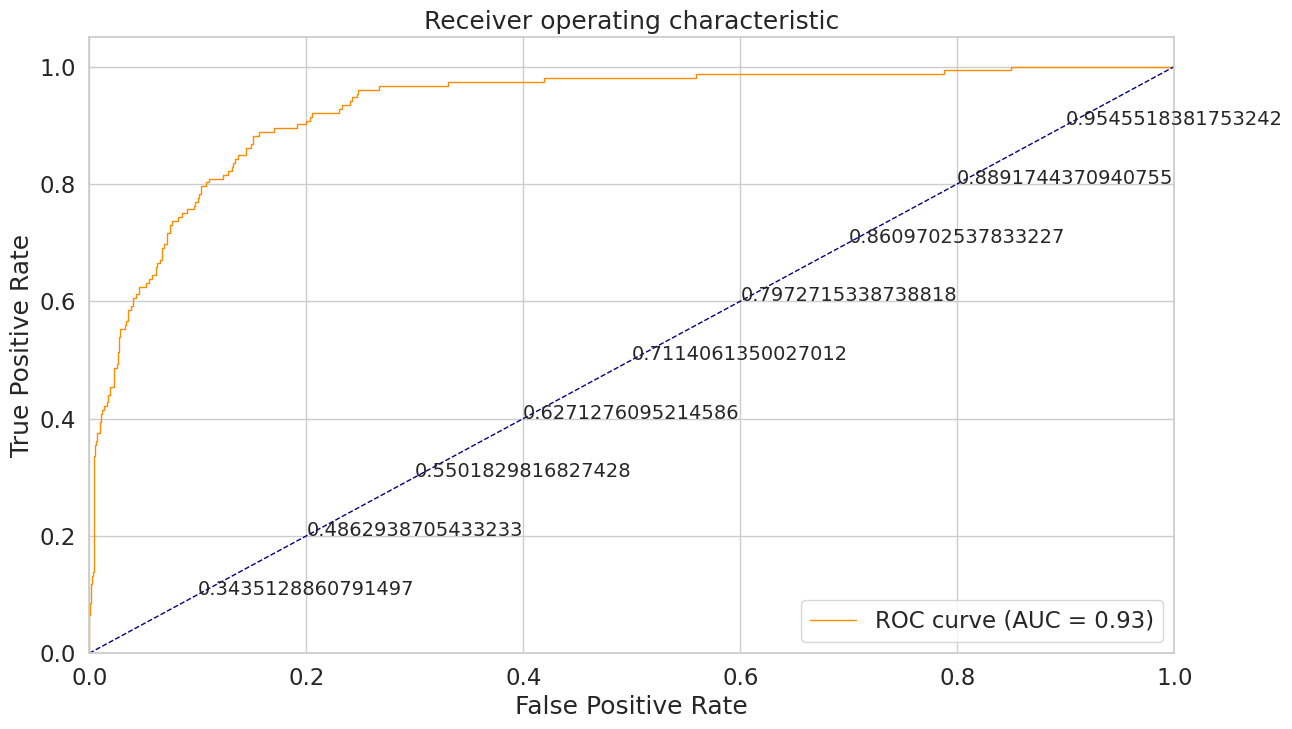

In [47]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val, rfc.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (AUC = %0.2f)' % roc_auc)

for label in range(1,10,1):
    plt.text((10-label)/10,(10-label)/10,thresholds[label*15],fontdict={'size': 14})

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Random Forest : TPR Vs FPR

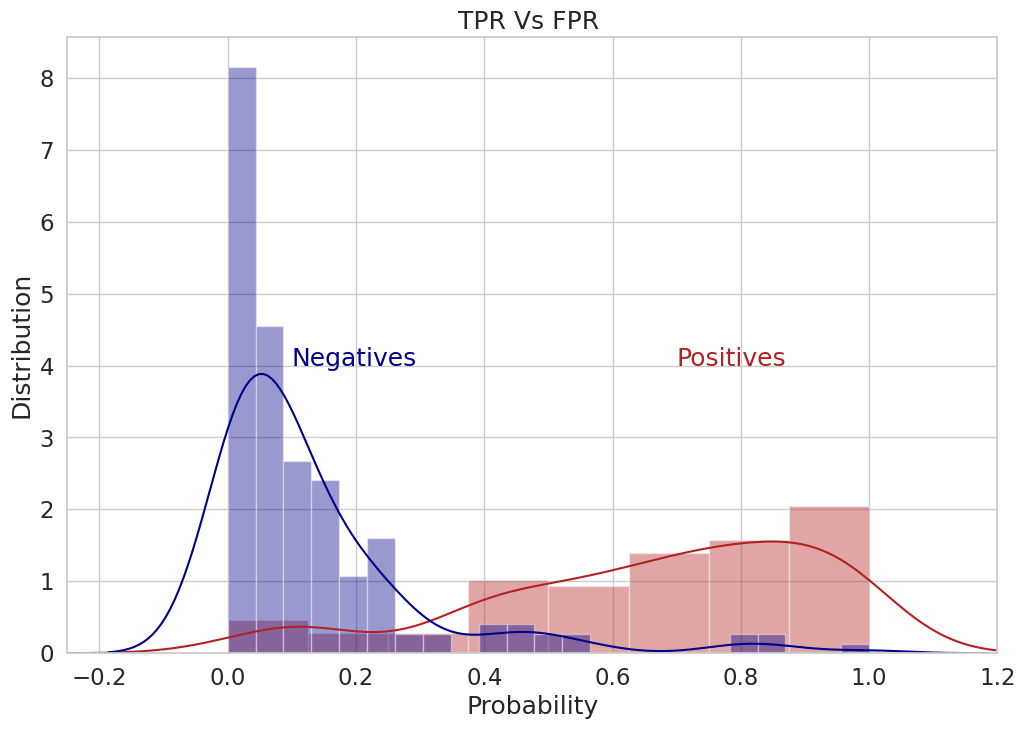

In [48]:
fig = plt.figure(figsize=(12,8))

sns.distplot(tpr,color='firebrick')

sns.distplot(fpr,color='darkblue')
plt.title('TPR Vs FPR ')
plt.xlim([-.25, 1.2])

plt.text(0.1,4,'Negatives',color='darkblue')
plt.text(0.7,4,'Positives',color='firebrick')
plt.xlabel('Probability')
plt.ylabel('Distribution')
plt.show()

In [49]:
rfc_train_pred = (rfc.predict_proba(X_train)[:,1]>0.5).astype(bool)   # Set threshold to 0.5
rfc_val_pred = (rfc.predict_proba(X_val)[:,1]>0.5).astype(bool)# Set threshold to 0.5

Random Forest : Model Evaluation

In [50]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix,accuracy_score,cohen_kappa_score,roc_auc_score,f1_score,roc_curve

cm0 = confusion_matrix(y_train, rfc_train_pred,labels=[1,0])
print('Confusion Matrix Train : \n', cm0)

cm1 = confusion_matrix(y_val, rfc_val_pred,labels=[1,0])
print('Confusion Matrix Test: \n', cm1)

total0=sum(sum(cm0))
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy0=(cm0[0,0]+cm0[1,1])/total0
print ('Accuracy Train : ', accuracy0)

accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy Test : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

KappaValue=cohen_kappa_score(y_val, rfc_val_pred)
print("Kappa Value :",KappaValue)
AUC=roc_auc_score(y_val, rfc_val_pred)
print("AUC         :",AUC)


print("F1-Score Train",f1_score(y_train,rfc_train_pred))
print("F1-Score Validation : ",f1_score(y_val, rfc_val_pred))

Confusion Matrix Train : 
 [[ 319   35]
 [ 389 3044]]
Confusion Matrix Test: 
 [[ 124   28]
 [ 182 1289]]
Accuracy Train :  0.8880380248217586
Accuracy Test :  0.8706099815157117
Sensitivity :  0.8157894736842105
Specificity :  0.876274643099932
Kappa Value : 0.47589611108548224
AUC         : 0.8460320583920713
F1-Score Train 0.60075329566855
F1-Score Validation :  0.5414847161572053


Random Forest : Feature Importance

In [51]:
feature_list = list(Test_category_removed_groupedbyProv_PF.columns)
# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list[1:], importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
print('Top -20 features impacting Random forest model and their importance score :- \n',)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:15]];

Top -20 features impacting Random forest model and their importance score :- 

Variable: PerProviderAvg_InscClaimAmtReimbursed Importance: 0.09
Variable: InscClaimAmtReimbursed Importance: 0.07
Variable: PerAttendingPhysicianAvg_InscClaimAmtReimbursed Importance: 0.07
Variable: PerOperatingPhysicianAvg_InscClaimAmtReimbursed Importance: 0.06
Variable: PerClmAdmitDiagnosisCodeAvg_InscClaimAmtReimbursed Importance: 0.04
Variable: PerClmAdmitDiagnosisCodeAvg_DeductibleAmtPaid Importance: 0.04
Variable: PerClmDiagnosisCode_1Avg_DeductibleAmtPaid Importance: 0.04
Variable: PerOperatingPhysicianAvg_IPAnnualReimbursementAmt Importance: 0.03
Variable: ClmCount_Provider_ClmDiagnosisCode_7 Importance: 0.03
Variable: ClmCount_Provider_ClmDiagnosisCode_8 Importance: 0.03
Variable: ClmCount_Provider_ClmDiagnosisCode_9 Importance: 0.03
Variable: DeductibleAmtPaid    Importance: 0.02
Variable: AdmitForDays         Importance: 0.02
Variable: PerProviderAvg_DeductibleAmtPaid Importance: 0.02
Variable: 

Random Forest : Prediction on Unseen Data

In [52]:
## Lets predict on Test data

rfc_test_pred = rfc.predict(X_teststd)

In [53]:
rfc_test_pred=pd.DataFrame(rfc_test_pred)
rfc_test_pred.head(5)

,0
0,0
1,0
2,0
3,0
4,0


In [54]:
## Lets Replace 1 with Yes and 0 With No

Replacement = {1:'Yes',0:'No'}

Labels=rfc_test_pred[0].apply(lambda x : Replacement[x])

In [55]:
Labels.value_counts()

No     1094
Yes     259
Name: 0, dtype: int64

In [56]:
submission_rfc=pd.DataFrame({"Provider":Test_category_removed_groupedbyProv_PF.Provider})
submission_rfc['PotentialFraud']=Labels
submission_rfc.shape

(1353, 2)

In [57]:
submission_rfc

,Provider,PotentialFraud
0,PRV51002,No
1,PRV51006,No
2,PRV51009,No
3,PRV51010,No
4,PRV51018,No
...,...,...
1348,PRV57713,No
1349,PRV57726,No
1350,PRV57745,No
1351,PRV57749,No


In [58]:
print('Shape Of Submission',submission_rfc.shape)

Shape Of Submission (1353, 2)


In [59]:
#write Submission file

submission_rfc.to_csv(PATH + "Submission_Random_Forest_Estimator_F1_60_estimators_3000(1).csv",index=False)

With just 2 layers and 100 epochs we achieved F1 score 0.57.

Our model seems to catch a lot of the fraudulent cases. The number of normal transactions classified as frauds is really high. Based on business decision ,one can set threshold to create a tradeoff between Fraud and Non Fraud class predictions. Adding More data time to time and training will improve the performance of detection of new fraud patterns and help us to understand Providers fradulent behaviour.

# Summary of Project

In this Project,I have used Supervised and Unsupervised machine learning algorithms to classify Fradulent behaviour of Healthcare providers.For the purpose of classifying providers in Fraud and Non Fraud category I used following methods:-

1) Feature Engineering

Medicare fraud is categorised as organized crime which involves peers working together to create fraud transactions of claims.Adding features from grouping them helped in improving accuracy of prediction and fraud pattern recognition. Grouping and aggregating numeric features to provider level helped in detecting behaviour of their transactions overall.

2) Logistic Regression Classifier

Features derived from above step are trained using logistic regression and evaluated.My decision of choosing LR is to check linear behaviour between dependent and independent variables.Also Logistic model adds explicability to the predictions. Performance of the LR model showcase the linearity between variables.

3) Random Forest Classifier

One of benefits of Random forest which excites most is, the power of handle large data set with higher dimensionality. It can handle thousands of input variables and identify most significant variables. Further, the model outputs Importance of variable, which can be a very handy feature.It also checks for non linearity between variables.

4) Autoencoders

Autoencoders are neural networks that aims to copy their inputs to their outputs. They work by compressing the input into a latent-space representation, and then reconstructing the output from this representation. My aim for the project is to train non fraud data using autoeencoder and reconstructing it back.While reconstructing Faud data it will create an error,called as reconstruction error.Based on the threshold setting of reconstruction errors, we can easily predict Fraudulent behaviour of healthcare provider.

Conclusion Important Features In this Project ,I studied behaviour of Providers and found following important features impactful in predicting Fraud/NonFraud are folowing:

1) PerProviderAvg_InscClaimAmtReimbursed( Importance: 8%)

2) InscClaimAmtReimbursed (Importance: 7%)

3) PerAttendingPhysicianAvg_InscClaimAmtReimbursed (Importance: 7%)

4) PerOperatingPhysicianAvg_InscClaimAmtReimbursed (Importance: 6%)

5) PerClmAdmitDiagnosisCodeAvg_InscClaimAmtReimbursed (Importance: 4%)

Model Performance Based on business requirement,Threshold can be set on prediction probabilities.This threshold can be varied for different performance of these models.Recall and Precision tradeoff is entirely based on business decision.

Our models consistentently performed with ~0.90 Accuracy, ~0.80 AUROC score and ~0.55 Kappa Score.



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




Model Improvement Based on the above model performance ,there is a scope in improving model performance by :

1) Adding more fraud data to the training dataset help in predicting unseen fraudulent behaviour time to time.

2) Ensembling methods with parameter tuning can improve performance of the models.

3) Vectorizing Medical codes(ICD 9 codes) with Count Vectoriser may add performance imporvement